In [2]:
import jax.numpy as jnp
import jax.lax as lax
import matplotlib.pyplot as plt


from scipy.integrate import simpson
import numpy as np
import pymaster as nmt
import healpy as hp
import gc
import time
from tqdm import tqdm
%matplotlib inline

In [3]:
def build_binning_matrix(edges, lmax):
    nbins = len(edges) - 1
    lmin = edges[0]
    B = np.zeros((nbins, lmax - lmin))
    ell_eff = np.zeros(nbins)
    for b in range(nbins):
        ell_min, ell_max = edges[b], edges[b + 1]
        ells_in_bin = np.arange(ell_min, ell_max)
        Δℓ = len(ells_in_bin)
        if Δℓ > 0:
            B[b, ells_in_bin - lmin] = 1.0 / Δℓ
            ell_eff[b] = np.mean(ells_in_bin)
    return B, ell_eff

In [20]:
from utils2 import *
n_sources = [10000]
nside = 256
npix = hp.nside2npix(nside)
sel = np.ones(npix)
nside = 256
nell = 30
lmin = 2
lmax = 3*nside - 1
edges = np.unique(np.geomspace(lmin,3*nside - 1,nell).astype(int))
# edges = np.arange(lmin, 3*nside + 1)
cl_DMDM = np.load("/home/s59efara_hpc/covariance/test_cl_kappadm.npy")[:, 0 ,0]
alm = hp.synalm(cls=cl_DMDM, lmax = lmax)
map = hp.alm2map(alm, nside=nside, lmax=lmax)



variance_list = []
variance_list2 = []
variance_list3 = []

for n_samples in n_sources:
    print('sampling on a sphere')
    (gl ,gb),  _ = get_pos(n_samples, 'random', sel, nside)
    
    sin_gl = np.sin(gl*np.pi/180)
    cos_gl = np.cos(gl*np.pi/180)
    sin_gb = np.sin(gb*np.pi/180)
    cos_gb = np.cos(gb*np.pi/180)

    cos_theta = sin_gb[None,:] * sin_gb[:, None] + cos_gb[None,:] * cos_gb[:, None] * np.cos(gl[None,:]*np.pi/180 - gl[:, None]*np.pi/180)
    np.fill_diagonal(cos_theta, 1)
    
    print('calculating the mode coupling matrix')
    ipix = hp.ang2pix(nside, gl, gb, lonlat=True)
    w = np.ones_like(ipix)
    # beware of the binning scheme and the values to be added to the  
    b = nmt.NmtBin.from_edges(edges[:-1], edges[1:])
    f_vals = map[ipix] - np.mean(map[ipix])
    f_nmt = nmt.NmtFieldCatalog(positions = [gl, gb], weights=w, field = f_vals, lmax=b.lmax, lonlat=True)
    wasp = nmt.NmtWorkspace.from_fields(f_nmt, f_nmt, b)
    
    
    Sl_coupled = nmt.compute_coupled_cell(f_nmt, f_nmt) # the coupled, noise subtracted power spectrum 
    Nf = f_nmt.Nf
    Sl = wasp.decouple_cell(Sl_coupled)
    ells = b.get_effective_ells()
    
    
    
    mcm = jnp.asarray(wasp.get_coupling_matrix())
    mcm_inv = np.linalg.inv(mcm)
    var_f = np.var(f_vals)
    print('calculating Paij')
    # Recurrence: (l+1) P_{l+1} = (2l+1)x P_l - l P_{l-1}
    def body_fn(carry, l):
        P_lm1, P_l = carry
        P_lp1 = ((2*l + 1)*cos_theta*P_l - l*P_lm1) / (l + 1)
        return (P_l, P_lp1), P_lp1

    # Initialize P_0 = 1, P_1 = x
    carry_init = (jnp.ones_like(cos_theta), cos_theta)

    # Run scan from l=1 to Lmax-1
    _, P_all = lax.scan(body_fn, carry_init, jnp.arange(2, edges[-1]))
    P_all = jnp.concatenate([
        jnp.ones_like(cos_theta)[None, :],   # P_0
        cos_theta[None, :],                  # P_1
        P_all                        # P_2 ... P_Lmax
    ], axis=0)
    
    full_ells = jnp.arange(0, edges[-1])
    
    Sl_unbinned = b.unbin_cell(Sl)[0]
    signal_corr = jnp.einsum('l, lij->ij', (2*full_ells + 1) *Sl_unbinned, P_all)/4./np.pi
    
    unit_matrix = np.zeros_like(cos_theta)
    np.fill_diagonal(unit_matrix, 1)
    
    
    field_variance = jnp.sum((2*full_ells + 1)*Sl_unbinned)/4./np.pi
    noise_variance = var_f - field_variance
    
    
    
    Nw = np.sum(w*w)/4./np.pi
    Nl = Nw*noise_variance
    

    # noise_corr = jnp.einsum('l, lij->ij', (2*full_ells + 1) *Nl, P_all)/4./np.pi
    noise_corr = unit_matrix*noise_variance
    full_field_corr =  signal_corr + noise_corr
    
    
    
    w_i_j = w[None, :]*w[:, None]
    np.fill_diagonal(w_i_j, 0)
    
    
    Binning, ell_eff = build_binning_matrix(edges, edges[-1])
    Binning = jnp.array(Binning)

    
    
    intermediate_step = jnp.einsum('ij, aij->aij', w_i_j, P_all)
    
    # direct_sum = 2*jnp.einsum('aij, bkm, ik, jm->ab', intermediate_step, intermediate_step, full_field_corr, full_field_corr)/(4*np.pi)**2
    
    print('summing terms')
    direct_sum = 2*jnp.einsum('i, j, ij, aij, k, m, km, bkm, ik, jm->ab', w, w, 1 - unit_matrix, P_all, w, w, 1- unit_matrix, P_all, full_field_corr, full_field_corr)/(4*np.pi)**2
    
    
    
    # direct_sum = 2*jnp.einsum('ij, aij, km, bkm, ik, jm->ab', w_i_j, P_all, w_i_j, P_all, full_field_corr, full_field_corr)/(4*np.pi)**2
    
    term1 = mcm_inv @ direct_sum @ mcm_inv.T
    term1 = term1[lmin:, lmin:]
    term1_binned = Binning @ term1 @ Binning.T
    variance_list.append(jnp.diag(term1_binned))
    
    
    
    
    
'''    direct_sum2 = 2*jnp.einsum('ik, jm, i, j, ij, aij, k, m, km, bkm, ik, jm->ab', unit_matrix, unit_matrix, w, w, 1- unit_matrix, P_all, w, w, 1- unit_matrix, P_all, full_field_corr, full_field_corr)/(4*np.pi)**2
    term2 = mcm_inv @ direct_sum2 @ mcm_inv.T
    term2 = term2[lmin:, lmin:]
    term2_binned = Binning @ term2 @ Binning.T
    variance_list2.append(jnp.diag(term2_binned))
    
    
    
    direct_sum3 = jnp.einsum('i, j, aij, bij->ab', w**2, w**2, P_all, P_all)/(4*np.pi)**2 - jnp.sum(w**4)/(4*np.pi)**2
    matrix_term3 = 2*direct_sum3*((var_f)**2)
    term3 = mcm_inv @ matrix_term3 @ mcm_inv.T
    term3 = term3[lmin:, lmin:]
    term3_binned = Binning @ term3 @ Binning.T
    variance_list3.append(jnp.diag(term3_binned))'''
    
    

sampling on a sphere


KeyboardInterrupt: 

In [ ]:
data = np.load('/home/s59efara_hpc/covariance/data_sets/varied_numbers_compare_fixed_field_wide_bins.npy')
data2 = np.load('/home/s59efara_hpc/covariance/data_sets/varied_numbers_compare_fixed_field_wide_bins.npy')


In [17]:
ells = b.get_effective_ells()

In [18]:
import plothist

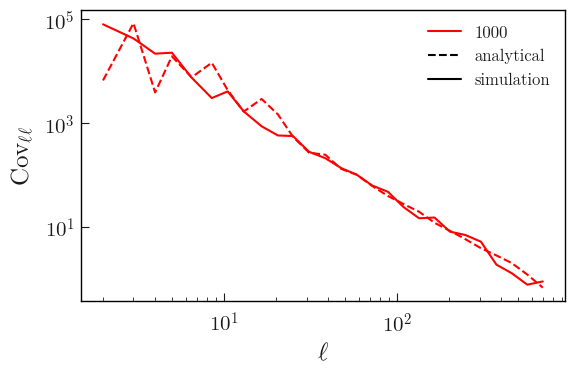

In [ ]:
color = ['r', 'b', 'g']

# fig, ax = plt.subplots(figsize = (12, 8))

for i in range(len(n_sources)):
    ls, cls, sigma, Nf, _ = data[i]
    ls2, _, sigma2, _, _ = data2[i]
    
    plt.loglog(ls, sigma, color = color[i], label = n_sources[i])
    plt.loglog(ells, variance_list[i], ls = '--', color = color[i])
    
    

plt.axhline(-1, ls = '--', color = 'black', label = 'analytical')
plt.axhline(-1, color = 'black', label = 'simulation')


plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cov_{\ell \ell}$')
plt.legend()
plt.tight_layout()
# plt.savefig('figs/full_covariance_plot.png', dpi = 300)
